In [22]:
from collections import defaultdict
from pathlib import Path

import json

from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

In [23]:
def get_headers(df):
    keys = list(df.keys())[1:]
    headers = list()
    for key in keys:
        key = '_'.join(key.split('_')[:-2]).lower()
        if key not in headers:
            headers.append(key)
        else:
            break
    assert(len(set(headers)) == len(headers))
    return headers

In [15]:
data = torch.load('../new-metric/data/mhist_data.pt')

In [24]:
data = defaultdict(dict)
for data_dir in Path('.').iterdir():
    if data_dir.name in {'MHIST'}:
        data[data_dir.name] = defaultdict(dict)
        for exp_dir in data_dir.iterdir():
            if not exp_dir.is_dir():
                continue
            data[data_dir.name][exp_dir.name] = defaultdict(dict)
            for opt_dir in exp_dir.iterdir():
                print(opt_dir)
                avg_in_KG = 0
                avg_out_KG = 0
                avg_in_rank = 0
                avg_out_rank = 0
                avg_in_MC = 0
                avg_out_MC = 0
                avg_train_acc = 0
                avg_test_acc = 0
                avg_max_test = 0 
                avg_max_train = 0
                max_test_accs = list()
                max_train_accs = list()
                qcs = list()
                avg_qc = 0
                empty = True
                avg_train_loss = 0
                avg_test_loss = 0
                train_offset = 0
                test_auc = 0
                max_test_aucs = list()
                lrs = None
                for i, f in enumerate(opt_dir.iterdir()):
                    empty = False
                    if f.suffix == '.xlsx':
                        df = pd.read_excel(f)
                        headers = get_headers(df)
                        print(headers)
                        print(f.name)
                        df = df.T
                        in_KG = np.asarray(
                            df.iloc[headers.index('in_s') + 1::len(headers),
                                    :])
                        if data_dir.name == 'MHIST':
                            assert len(in_KG[:, -1]) == 150, f'{in_KG.shape}'
                        else:
                            assert len(in_KG[:, -1]) == 250, f'{in_KG.shape}'
                        out_KG = np.asarray(
                            df.iloc[headers.index('out_s') + 1::len(headers),
                                    :])
                        in_rank = np.asarray(
                            df.iloc[headers.index('in_rank') + 1::len(headers),
                                    :])
                        out_rank = np.asarray(
                            df.iloc[headers.index('out_rank') + 1::len(headers),
                                    :])
                        in_MC = np.asarray(
                            df.iloc[headers.index('in_condition') + 1::len(headers),
                                    :])
                        out_MC = np.asarray(
                            df.iloc[headers.index('out_condition') + 1::len(headers),
                                    :])
                        in_MC[in_MC == 0] = 500
                        out_MC[out_MC == 0] = 500
                        avg_in_KG += in_KG
                        avg_out_KG += out_KG
                        avg_in_rank += in_rank
                        avg_out_rank += out_rank
                        avg_in_MC += in_MC
                        avg_out_MC += out_MC
                        QC = np.arctan2((in_KG[-1, :] + out_KG[-1, :]), 
                            1 - 1 / ((in_MC[-1, :]  + out_MC[-1, :])))
                        QC = np.linalg.norm(QC) / np.sqrt(in_KG.shape[1])
                        avg_qc += QC
                        qcs.append(QC)
                        tag = 'test_acc1'
                        if 'test_acc1' not in headers:
                            tag = 'test_acc'
                            if 'test_acc' not in headers:
                                tag = 'acc'
                        test_acc = np.asarray(
                            df.iloc[headers.index(tag) + 1::len(headers), :])
                        if 'SAM' in opt_dir.name:
                            max_test_accs.append(np.max(test_acc[:, 0][:130]))
                        else:
                            max_test_accs.append(np.max(test_acc[:, 0]))
                        avg_max_test += np.max(test_acc[:, 0])
                        auc = np.asarray(
                            df.iloc[headers.index('test_auc') + 1::len(headers), :])
                        if 'SAM' in opt_dir.name:
                            max_test_aucs.append(np.max(auc[:, 0][:130]))
                        else:
                            max_test_aucs.append(np.max(auc))
                        test_auc += auc[:, 0]
                        tag = 'train_acc1'
                        avg_test_acc += test_acc
                        if 'train_acc1' not in headers:
                            tag = 'train_acc'
                        try:
                            train_acc = np.asarray(
                                df.iloc[headers.index(tag) + 1::len(headers), :])
                            avg_train_acc += train_acc
                            avg_max_train += np.max(train_acc[:, 0])
                            max_train_accs.append(np.max(train_acc[:, 0]))
                        except Exception:
                            train_offset += 1
                        train_loss = np.asarray(
                                    df.iloc[headers.index('train_loss') + 1::len(headers), :])
                        avg_train_loss += train_loss
                        try:
                            test_loss = np.asarray(
                                        df.iloc[headers.index('test_loss') + 1::len(headers), :])
                            avg_test_loss += test_loss
                        except Exception:
                            avg_test_loss += np.zeros_like(avg_test_loss)
                        if 'learning_rate' in headers:
                            lr = np.asarray(
                                 df.iloc[headers.index('learning_rate') + 1::len(headers), :])
                            lrs = lr if lrs is None else np.dstack((lrs, lr))

                if empty:
                    print("EMPTY")
                    continue
                test_auc /= (i + 1)
                avg_in_KG /= (i + 1)
                avg_out_KG /= (i + 1)
                avg_in_rank /= (i + 1)
                avg_out_rank /= (i + 1)
                avg_in_MC /= (i + 1)
                avg_out_MC /= (i + 1)
                avg_train_acc /= (i - train_offset + 1)
                avg_test_acc /= (i + 1)
                avg_qc /= (i + 1)
                avg_train_loss /= (i + 1)
                avg_test_loss /= (i + 1)
                avg_max_test /= (i + 1)
                avg_max_train /= (i - train_offset + 1)
                data[data_dir.name][exp_dir.name][opt_dir.name] = {
                    "in_KG": avg_in_KG,
                    "out_KG": avg_out_KG,
                    "in_rank": avg_in_rank,
                    "out_rank": avg_out_rank,
                    "in_MC": avg_in_MC,
                    "out_MC": avg_out_MC,
                    "QC": avg_qc,
                    "train_loss": avg_train_loss,
                    "test_loss": avg_test_loss,
                    "train_acc": avg_train_acc,
                    "test_acc": avg_test_acc,
                    "avg_max_test": avg_max_test,
                    "avg_max_train": avg_max_train,
                    "max_test_accs": max_test_accs,
                    "max_train_accs": max_train_accs,
                    "QCs": qcs,
                    "test_auc": test_auc,
                    "max_test_aucs": max_test_aucs,
                    "learning_rates": lrs,
                }
                # n_grid = np.round(np.linspace(
                #     0, QC.shape[0]-1, QC.shape[1]))
                # n_grid = n_grid.astype(int)
                # plt.imshow(QC[n_grid, :].T,
                #            cmap='jet', vmin=0, vmax=np.pi/4)
                # locs, labels = plt.xticks()
                # x_labels = np.round(np.linspace(1, len(n_grid), len(locs)))
                # x_labels = x_labels.astype(int)
                # x_labels = n_grid[x_labels-1]
                # plt.xticks(locs, x_labels)
                # fname = f'figures/{data_dir.name}_{exp_dir.name}_{opt_dir.name}.png'
                

MHIST/ResNet34/SAM_StepDecay
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-05-12-12-48-05_trial=3_ResNet34_MHIST_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-05-12-13-51-43_trial=4_ResNet34_MHIST_SAMmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
results_date=2021-05-12-09-36-42_trial=0_ResNet34_MHI

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_ResNet34_MHIST_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet34_MHIST_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_ResNet34_MHIST_AdamPweight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.001.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_r

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_ResNet18_MHIST_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=0_ResNet18_MHIST_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=4_ResNet18_MHIST_SGDPmomentum=0.9_weight_decay=0.0005_StepLRstep_size=25.0_gamma=0.5_LR=0.1.xlsx
['train_acc1', 'train_acc5', 'train_loss', 

['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'rank_velocity', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=1_MobileNetV2_MHIST_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'rank_velocity', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=2_MobileNetV2_MHIST_Adasmomentum=0.9_weight_decay=0.0005_beta=0.98_linear=0.0_gamma=0.5_step_size=25.0_None_LR=0.03.xlsx
['train_acc1', 'train_acc5', 'train_loss', 'in_s', 'out_s', 'fc_s', 'in_rank', 'out_rank', 'fc_rank', 'in_condition', 'out_condition', 'train_auc', 'rank_velocity', 'learning_rate', 'test_auc', 'test_acc1', 'test_acc5', 'test_loss']
trial=3_MobileNetV2_MHIST_Adasmomentum=0.9_weig

In [16]:
print(data['MHIST'].keys())

dict_keys(['ResNet34', 'ResNet18', 'MobileNetV2'])


In [10]:
torch.save(data, '../new-metric/data/mhist_data.pt')

In [17]:
def slice(_list, freq):
    _list = list(_list)
    x =  _list[::freq]
    x.append(_list[-1])
    return x

ResNet34


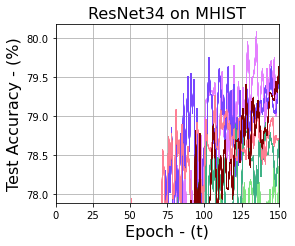

ResNet18


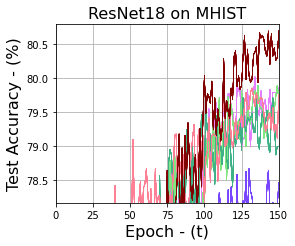

MobileNetV2


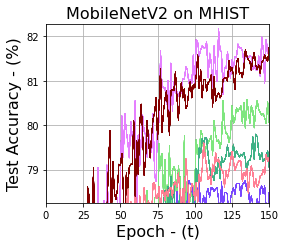

ResNet34


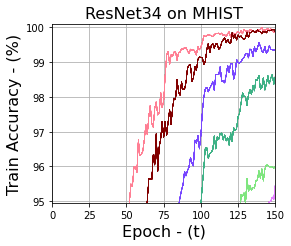

ResNet18


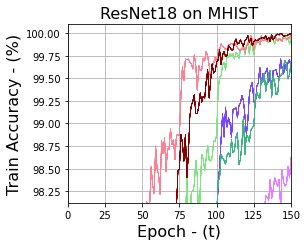

MobileNetV2


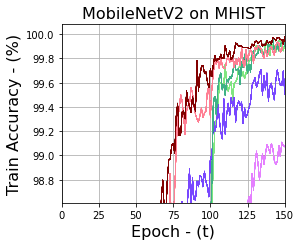

ResNet34


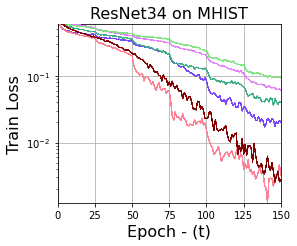

ResNet18


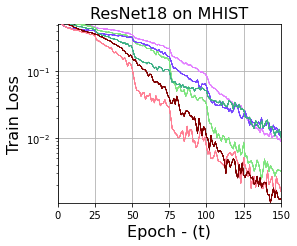

MobileNetV2


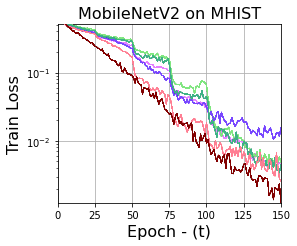

In [21]:
# %rm -r mhist-figures
%mkdir -p mhist-figures
COLORS = {'SGD':     np.array((127, 230, 127)) / 255,
         'RAdam':      np.array((0, 212, 255))/255,
         'SAM':     np.array((229, 127, 255))/255,
         'Adam':     np.array((120, 70, 255))/255,
         'AdaGrad':      np.array((230, 240, 50))/255,
         'AdaBound': np.array((255, 178, 50))/255,
         'Adas':  np.array((130, 0, 0))/255,
         'SGDP':    np.array((62, 178, 134))/255,
         'AdamW':      np.array((174, 127, 255))/255,
         'SLS':    np.array((165, 102, 8))/255,
         'AdamP':    np.array((255, 127, 148))/255,
         'AdaBelief': np.array((251, 124, 12))/255}
tag = 'max_test_accs'
tag = 'test_acc'
for tag in ['test_acc', 'train_acc', 'train_loss']:
    for net, opts in data['MHIST'].items():
        plt.close()
        fig, ax = plt.subplots(ncols=1, figsize=(4,4))
        print(net)
        max_auc = 0
        min_auc = 100
        max_std = 0
        d = dict()
        max_name = None
        for opt, metrics in opts.items():
#             print(opt)
#             print(np.mean(metrics[tag]) * 100, '+/-', np.std(metrics[tag]) * 100)
#             if np.mean(metrics[tag]) > max_auc:
            evaluator = np.max if 'acc' in tag else np.min
            if evaluator(metrics[tag]) > max_auc:
                max_name = opt.split("_")[0]
                max_std = np.std(metrics[tag])
    #             max_auc = np.mean(metrics[tag])
                max_auc = evaluator(metrics[tag])
            if evaluator(metrics[tag]) < min_auc:
                min_auc = evaluator(metrics[tag])
            d[opt.split('_')[0]] = (np.mean(metrics[tag]) * 100, 
                                    np.std(metrics[tag]) * 100)
            name = opt.split("_")[0]
            if tag == 'train_loss':
                mult = 1
            else:
                mult = 100
            ax.plot(slice(np.arange(150) + 1, 1), slice( mult * metrics[tag], 1), color=COLORS[name], linewidth=0.5,
                   zorder=10000 if 'Adas' in name else 100)
            ax.plot([], [], color=COLORS[name], label='RMSGD' if name == 'Adas' else name)
        string = ''
        for k in ['Adam', 'AdamP', 'SAM', 'SGD', 'SGDP', 'Adas']:
            if k == max_name:
                string += '{\color{best}$\mathbf{' + f'{d[k][0]:.2f}' + '_{' + f'{d[k][1]:.2f}' + '}}$}&'
            else:
                if d[k][0] + d[k][1] > max_auc - max_std:
                    string += '{\color{close}$\mathbf{' + f'{d[k][0]:.2f}' + '_{' + f'{d[k][1]:.2f}' + '}}$}&'
                else:
                    string += '$' + f'{d[k][0]:.2f}' + '_{' + f'{d[k][1]:.2f}' + '}$&'
        string = string[:-1]
        string += '\\\\'
#         print(string)
        ax.set_title(f"{net} on MHIST", fontsize=16)
        ax.set_xlabel("Epoch - (t)", fontsize=16)
        if tag == 'train_acc':
            ax.set_ylabel(f"Train Accuracy - (%)", fontsize=16)
        elif tag == 'test_acc':
            ax.set_ylabel(f"Test Accuracy - (%)", fontsize=16)
        else:
            ax.set_ylabel(f"Train Loss", fontsize=16)
#         if tag == 'max_test_accs' or tag == 'test_acc':
#             ax.set_ylim( 100 *0.75,  100 *max_auc)
#         else:
#             ax.set_ylim( 100 * 0.96,  100 *1)
        if 'acc' in tag:
            ax.set_ylim(min_auc * mult - 0.5, max_auc * mult + 0.1)
        else:
            ax.set_ylim(min_auc * mult, max_auc * mult + 0.5)
        ax.set_xlim(0, 150)
        if tag == 'train_loss':
            ax.set_yscale('log')
        ax.set_aspect(0.8 / ax.get_data_ratio(), adjustable='box')
        box = ax.get_position()
        box.y0 += 0.0
        box.y1 += 0.0
        ax.set_position(box)
        ax.grid(True, zorder=0)
    #     fig.legend(loc='upper center', bbox_to_anchor=(1.07, 2.905), ncol=7, prop={'size': 13})
        a = f'{tag}'
        fig.savefig(f'mhist-figures/mhist_{net.lower()}_{a}.png', bbox_inches='tight')
        plt.show()

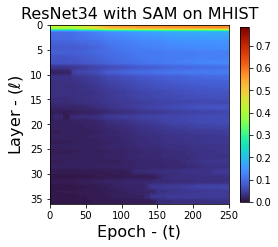

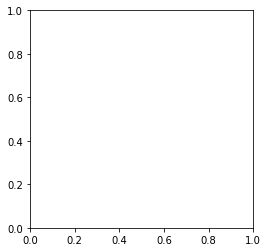

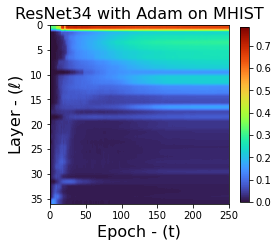

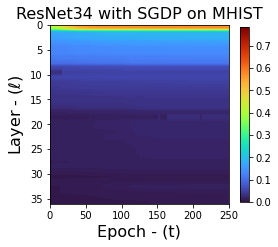

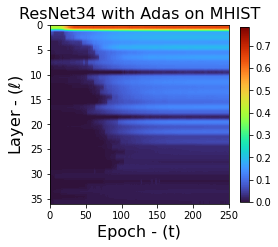

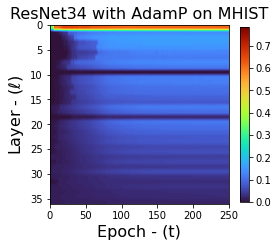

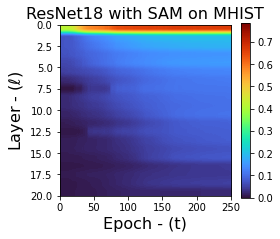

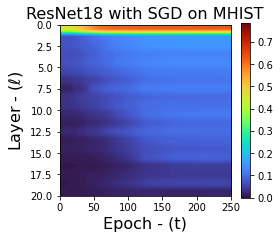

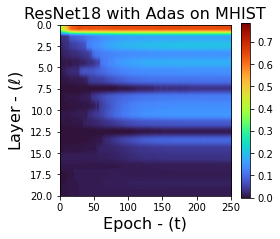

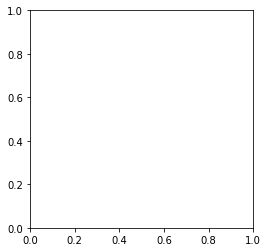

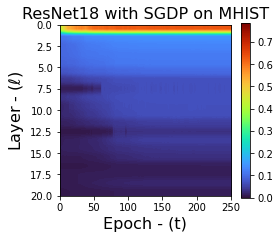

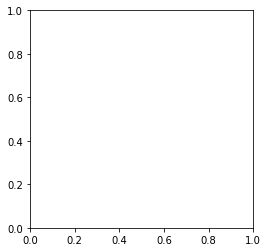

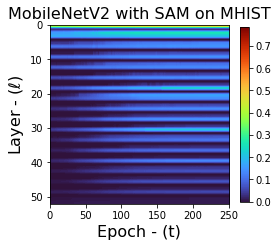

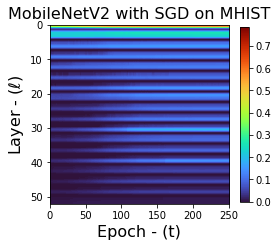

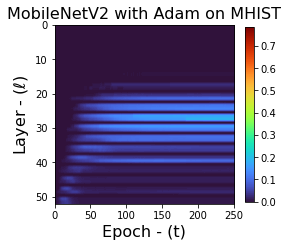

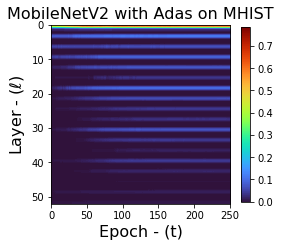

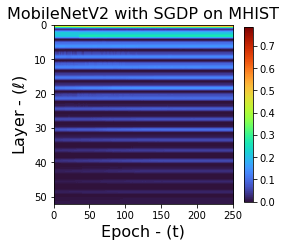

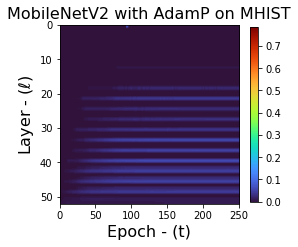

In [14]:
%rm -r heatmaps-mhist
%mkdir heatmaps-mhist
plt.close()
FONTSIZE = 16
for tag in ['KG']:
    for i, (dataset, exps) in enumerate(data.items()):
        if dataset not in {'CIFAR10'}:
            pass
        for net, opts in exps.items():
            if net not in {'ResNet50'}:
                pass
            for opt, metrics in opts.items():
                fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
                name = opt.split('_')[0] + ('' if 'Cutout' not in opt else 'C')
                if 'Cutout' in opt:
                    title = "{}$^{{{}}}$".format(opt.split('_')[0], 'C')
                else:
                    title = name
                if net == 'ResNet34' and opt == 'SGD_StepDecay':
                    continue
                if net == 'ResNet101' and opt == 'SLS':
                    continue
                if 'SLS' in opt:
                    continue
                if net == 'ResNet18' and 'Adam' in opt:
                    continue
                metrics['in_MC'] = np.nan_to_num(metrics['in_MC'], nan=1)
                metrics['out_MC'] = np.nan_to_num(metrics['out_MC'], nan=1)
                metrics['in_KG'] = np.nan_to_num(metrics['in_KG'], nan=0)
                metrics['out_KG'] = np.nan_to_num(metrics['out_KG'], nan=0)
                metrics['in_MC'][np.where(metrics['in_MC'] == 0)] = 1
                metrics['out_MC'][np.where(metrics['out_MC'] == 0)] = 1
                QC = np.arctan2((metrics[f'in_{tag}'] + metrics[f'out_{tag}']), 
                                1 - 1 / ((metrics['in_MC'] + metrics['out_MC'])))
                
                num_epoch, num_layers = metrics['in_KG'].shape
                n_grid = np.round(np.linspace(
                    0, QC.shape[0] - 1, QC.shape[1]))
                n_grid = n_grid.astype(int)
                heatmap = ax.imshow(QC.T,
                           cmap='turbo', vmin=0, vmax=np.pi/4, extent=[0, 250, num_layers, 0],)
                ax.set_aspect(1. / ax.get_data_ratio(), adjustable='box')
                ax.set_title(f"{net} with {title} on {dataset}", fontsize=FONTSIZE)
                ax.set_xlabel("Epoch - (t)", fontsize=FONTSIZE)
                ax.set_ylabel("Layer - ($\ell$)", fontsize=FONTSIZE)
                fig.colorbar(heatmap, ax=ax, shrink=0.7)
                fig.tight_layout()
                plt.savefig(f'heatmaps-mhist/{dataset.lower()}_{net.lower()}_{name.lower()}.png',
                           bbox_inches='tight')
                plt.show()
                plt.close()
            



MHIST
SAM_StepDecay
SGD_StepDecay
Adam_StepDecay
SGDP_StepDecay
Adas_StepDecay
AdamP_StepDecay
SAM_StepDecay
SGD_StepDecay
Adas_StepDecay
Adam_StepDecay
SGDP_StepDecay
AdamP_StepDecay
SAM_StepDecay
SGD_StepDecay
Adam_StepDecay
Adas_StepDecay
SGDP_StepDecay
AdamP_StepDecay


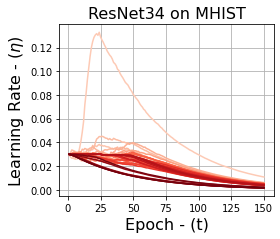

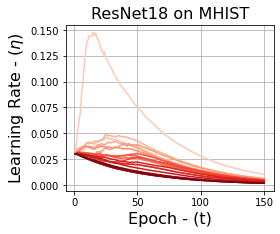

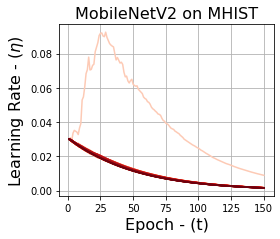

In [28]:
%mkdir -p learning-rate-figures
from matplotlib import cm
c = cm.get_cmap('Reds')
mini = 0.2
LOG = False
for dataset, nets in data.items():
    print(dataset)
    for net, opts in nets.items():
        for opt, metrics in opts.items():
            print(opt)
            if opt == 'Adas_StepDecay':
                fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
                learning_rates = metrics['learning_rates'].copy()
                learning_rates = np.mean(learning_rates, axis=2).T
                for i, lrs in enumerate(learning_rates):
                    ax.plot(np.arange(len(lrs)) + 1, lrs, color=c(mini + (1-mini)*i/len(learning_rates)))
                if LOG:
                    ax.set_yscale('log')
                ax.set_xlabel('Epoch - (t)', fontsize=16)
                ax.set_ylabel(r'Learning Rate - ($\eta$)', fontsize=16)
                ax.set_title(f'{net} on MHIST', fontsize=16)
                ax.set_aspect(0.8 / ax.get_data_ratio(), adjustable='box')
                fig.tight_layout()
                ax.grid(True)
                plt.savefig(f"learning-rate-figures/mhist_{net.lower()}.png", bbox_inches="tight")
